In [1]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nlppreprocess import NLP # pip install nlppreprocess
import en_core_web_sm
from nltk import pos_tag

#Model Selection and Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
dataset = pd.read_csv("train.csv")
final_test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [3]:
dataset.shape

(15819, 3)

In [4]:
final_test.shape

(10546, 2)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [6]:
dataset.head(2)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103


In [7]:
final_test.head(2)

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326


In [8]:
y = dataset['sentiment']
X = dataset.drop(columns=['sentiment', 'tweetid'])
F_test = final_test.drop(columns='tweetid')

In [9]:
X.head(2)

,message
0,PolySciMajor EPA chief doesn't think carbon di...
1,It's not like we lack evidence of anthropogeni...


In [10]:
y.unique()

array([ 1,  2,  0, -1], dtype=int64)

In [11]:
# Working_text to test
text = X.iloc[6,0]
print(text)

RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R


In [12]:
working_df = dataset.copy()

In [13]:
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']] # Labeling the target

In [14]:
working_df.head()

,sentiment,message,tweetid
0,Positive,PolySciMajor EPA chief doesn't think carbon di...,625221
1,Positive,It's not like we lack evidence of anthropogeni...,126103
2,News,RT @RawStory: Researchers say we have three ye...,698562
3,Positive,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,Positive,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [15]:
mpl.rcParams['figure.dpi'] = 180

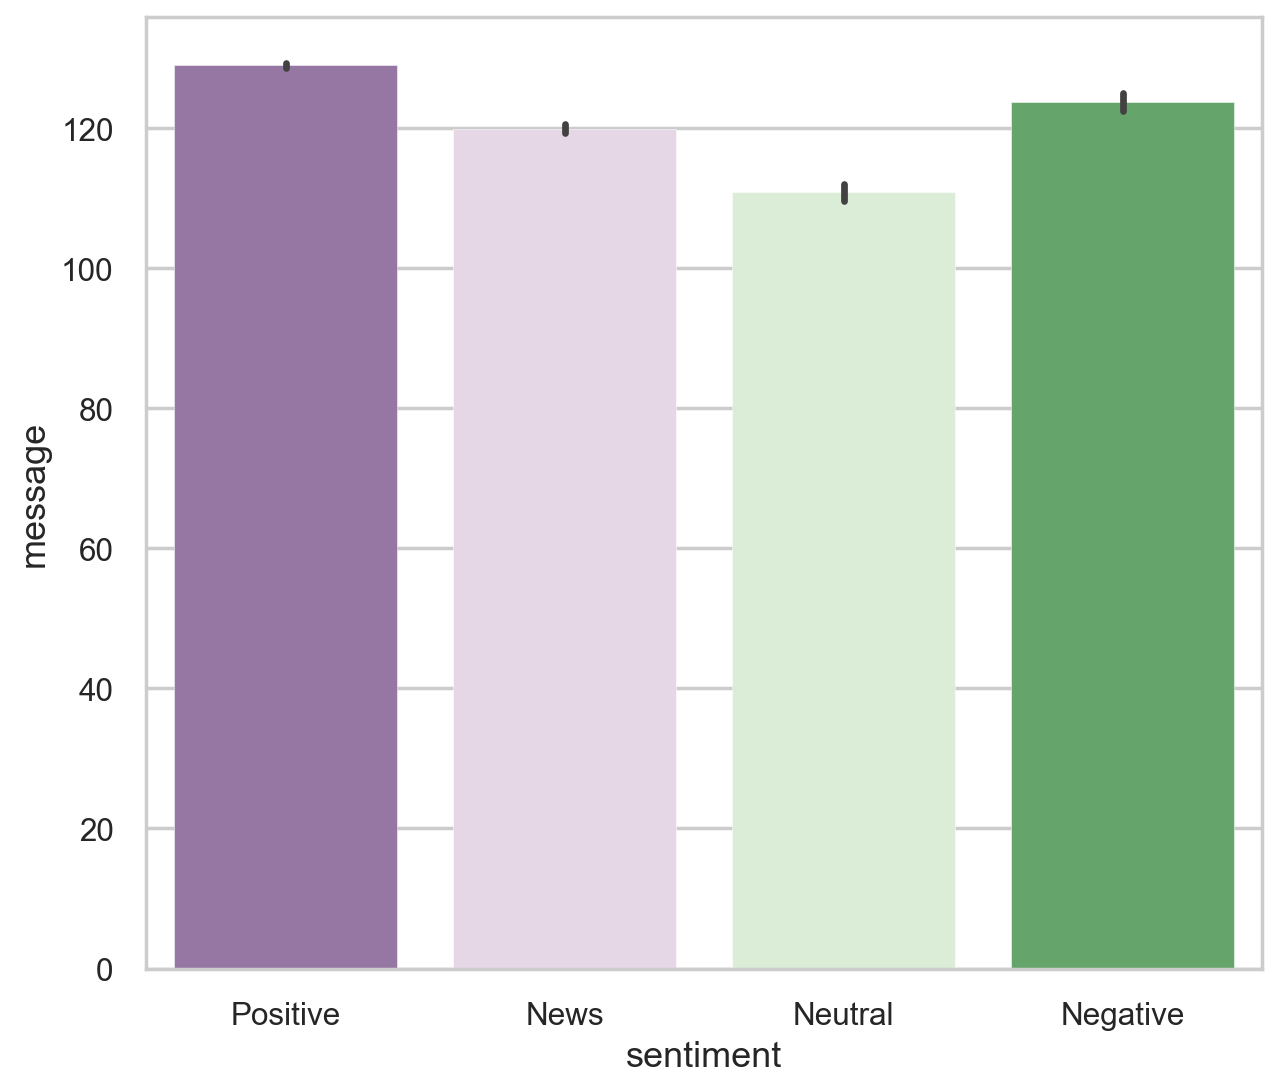

In [16]:
sns.barplot(x='sentiment', y=working_df['message'].apply(len) ,data = working_df, palette='PRGn')

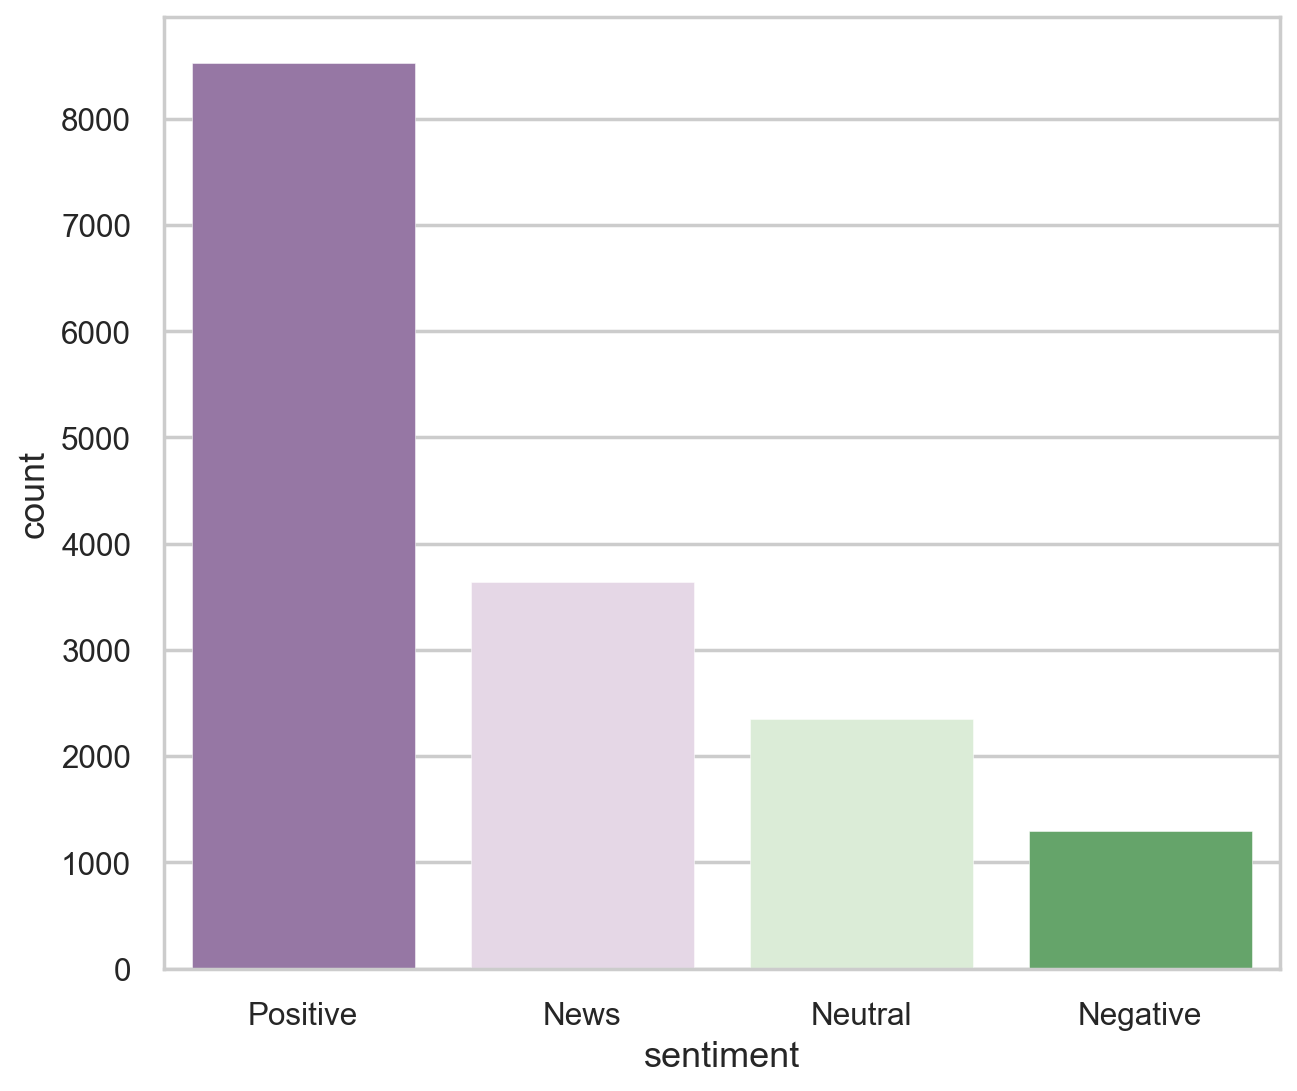

In [17]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')

Preprocessing

firstly, i want to see if any of the users are repeated.

In [18]:
working_df['users'] = [''.join(re.findall(r'@\w{,}', line)) if '@' in line else np.nan for line in X.message]


In [19]:
counts = working_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [20]:
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


In [21]:
repeated_tags_rate = round(counts['message'][counts['message'] > 1].sum() * 100/len(counts['message']), 0)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

86.0 percent of the data are from repeated tags


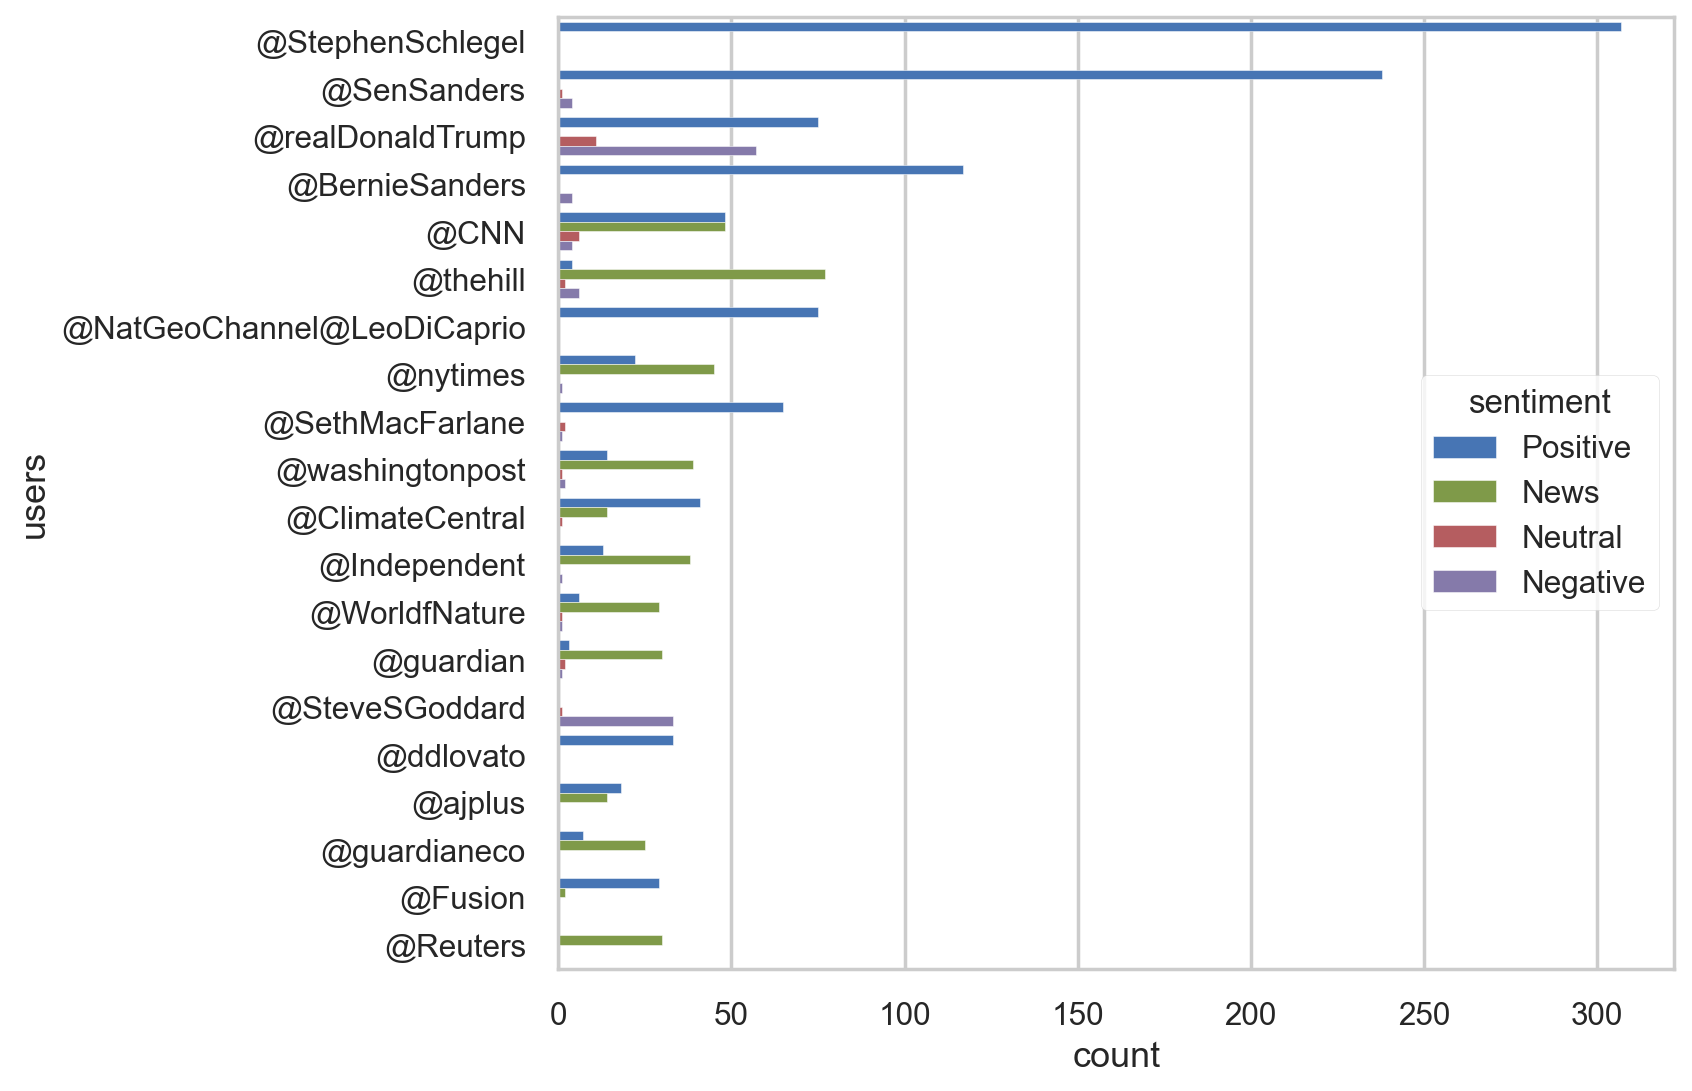

In [22]:
mpl.rcParams['figure.dpi'] = 180
sns.countplot(y="users", hue="sentiment", data=working_df,
              order=working_df.users.value_counts().iloc[:20].index)
#plt.xticks(rotation=90)

We will not, therefore, be removing users, as we can see that they have a contribute to the analysis

pip install nlppreprocess

In [23]:
from nlppreprocess import NLP
nlp = NLP()
nlp.process('shouldnt')

'should not'

In [25]:
nlp.process('There is no good here')

'There no good'

In [26]:
def cleaner(line):
    
    # print("Original:\n", line, '\n'*2)

    # Removes RT, url and trailing white spaces
    line = re.sub(r'^RT ','', re.sub(r'https://t.co/\w+', '', line).strip()) 
    # print("After removing RT, url and trailing white spaces:\n" + line, '\n'*2)

    # Removes puctuation
    punctuation = re.compile("[.;:!\'’‘“”?,\"()\[\]]")
    tweet = punctuation.sub("", line.lower()) 
    # print("After puctuation:\n", tweet, '\n'*2)

    # Removes stopwords
    nlp_for_stopwords = NLP(replace_words=True, remove_stopwords=True, remove_numbers=True, remove_punctuations=False) 
    tweet = nlp_for_stopwords.process(tweet) # This will remove stops words that are not necessary. The idea is to keep words like [is, not, was]
    # https://towardsdatascience.com/why-you-should-avoid-removing-stopwords-aa7a353d2a52
    # print("After removing stopwords:\n", tweet, '\n'*2)

    # tokenisation
    # We used the split method instead of the word_tokenise library because our tweet is already clean at this point
    # and the twitter data is not complicated
    tweet = tweet.split() 
    # print("After tokenisation:\n", tweet, '\n'*2)

    # POS 
    pos = pos_tag(tweet)
    # print("After POS:\n", pos, '\n'*2)

    # Stemming
    # stemmer = PorterStemmer()
    # tweet = ' '.join([stemmer.stem(word) for word in tweet])
    # print("After Stemming:\n", tweet, '\n'*2)

    # pos_only = [p for w, p in pos]
    # new_pos = zip(tweet.split(), pos_only)

    # Lemmatization

    lemmatizer = WordNetLemmatizer()
    tweet = ' '.join([lemmatizer.lemmatize(word, po[0].lower()) if po[0].lower() in ['n', 'r', 'v', 'a'] else word for word, po in pos])
    # tweet = ' '.join([lemmatizer.lemmatize(word, 'v') for word in tweet])
    # print("After Lemmatization:\n", tweet, '\n'*2)

    return tweet

In [27]:
text1 = cleaner(text)
# print('BEFORE')
# print(text, '\n'*2)
# print('AFTER')
# print(text1)
# # In the tweet below, you can see that "not" was added and kept, because the word is significant

In [28]:
X1 = X.message.apply(cleaner)

In [29]:
F_test1 = F_test.message.apply(cleaner)

In [30]:
# cv = CountVectorizer()
# X2 = cv.fit_transform(X1)
# F_test2 = cv.transform(F_test1)

In [32]:
from imblearn.over_sampling import SMOTE

# Separate input features and target

# setting up testing and training sets
# X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.25, random_state=27)

# sm = SMOTE(random_state=27, sampling_strategy='not majority', n_jobs=-1)
# X_train, y_train = sm.fit_resample(X_train, y_train)


In [33]:
# help(SMOTE)

Help on class SMOTE in module imblearn.over_sampling._smote:

class SMOTE(BaseSMOTE)
 |  SMOTE(*, sampling_strategy='auto', random_state=None, k_neighbors=5, n_jobs=None)
 |  
 |  Class to perform over-sampling using SMOTE.
 |  
 |  This object is an implementation of SMOTE - Synthetic Minority
 |  Over-sampling Technique as presented in [1]_.
 |  
 |  Read more in the :ref:`User Guide <smote_adasyn>`.
 |  
 |  Parameters
 |  ----------
 |  sampling_strategy : float, str, dict or callable, default='auto'
 |      Sampling information to resample the data set.
 |  
 |      - When ``float``, it corresponds to the desired ratio of the number of
 |        samples in the minority class over the number of samples in the
 |        majority class after resampling. Therefore, the ratio is expressed as
 |        :math:`\alpha_{os} = N_{rm} / N_{M}` where :math:`N_{rm}` is the
 |        number of samples in the minority class after resampling and
 |        :math:`N_{M}` is the number of samples in

In [34]:
# from sklearn.model_selection    import KFold, cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.linear_model import LogisticRegression


# for mod in models:
#     estimator = []
#     estimator.append(('cv', CountVectorizer()))
#     estimator.append(('tfidf', TfidfTransformer()))
#     estimator.append(('model', mod))
#     model = Pipeline(estimator)
    
#     kfold = KFold(n_splits=5, random_state=27)

#     results = cross_val_score(model, X1, y, cv=kfold, scoring='f1_weighted', n_jobs=-1)
#     print('C =', c)
#     print('results = ', results,'\nmean = ', np.mean(results), '\nstd = ', np.std(results))
#     print('\n'*2)

NameError: name 'c' is not defined

In [35]:
# help(KFold)

Help on class KFold in module sklearn.model_selection._split:

class KFold(_BaseKFold)
 |  KFold(n_splits=5, *, shuffle=False, random_state=None)
 |  
 |  K-Folds cross-validator
 |  
 |  Provides train/test indices to split data in train/test sets. Split
 |  dataset into k consecutive folds (without shuffling by default).
 |  
 |  Each fold is then used once as a validation while the k - 1 remaining
 |  folds form the training set.
 |  
 |  Read more in the :ref:`User Guide <cross_validation>`.
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default=5
 |      Number of folds. Must be at least 2.
 |  
 |      .. versionchanged:: 0.22
 |          ``n_splits`` default value changed from 3 to 5.
 |  
 |  shuffle : bool, default=False
 |      Whether to shuffle the data before splitting into batches.
 |      Note that the samples within each split will not be shuffled.
 |  
 |  random_state : int or RandomState instance, default=None
 |      When `shuffle` is True, `random_state` af

In [36]:
sample.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [37]:
# estimator1 = []
# # estimator1.append(('cv', CountVectorizer()))
# # estimator1.append(('tfidf', TfidfTransformer()))
# estimator1.append(('model', LogisticRegression(C=5)))
# model = Pipeline(estimator1)
# model.fit(X_train, y_train)
# y_pred = model.predict(F_test2)
# v1 = sample.copy()
# v1['tweetid'] = final_test['tweetid']
# v1['sentiment'] = y_pred
# v1.to_csv('log_c5_balanced_not_majority.csv', index=False)

In [38]:
# v1.head()